In [1]:
library(tidyverse)
library(arrow)
library(cowplot)
library(yardstick)

── Attaching core tidyverse packages ───────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ─────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘arrow’


The following object is masked from ‘package:lubridate’:

    duration


The following object is masked from ‘package:utils’:

    timestamp



Attaching package: ‘cowplot’


The following object is masked from ‘package:lubridate’:

    stamp


Warning message:
“package ‘yardstick’ was built under R version 4.3.3”

Attachi

In [2]:
sampled_df <- fs::dir_ls("plot_data", glob = "*sampled_variants_pvalues_*.parquet") %>%
    open_dataset() %>%
    as_tibble %>%
    select(-p_value_right, -quantile) %>%
    mutate(fraction = round(fraction, 2))

sampled_df %>% nrow

sampled_df %>% head(2)

[1] 74280000

phenotype_id,variant_id,p_value,p_value_direct,fraction
<chr>,<chr>,<dbl>,<dbl>,<dbl>
b_A01,1:1467485,0.3566614,0.02496682,0.1
b_A01,1:1472047,0.2435031,0.26422550,0.1


In [3]:
fit_quality_df <- read_parquet("plot_data/pca_fit_quality.parquet") %>%
    rename(phenotype_id = phenotype, r2 = rsq) %>%
    distinct 

fit_quality_df %>% nrow

fit_quality_df %>% head(2)

[1] 7428

phenotype_id,r2,fraction
<chr>,<dbl>,<dbl>
b_A01,0.001500541,0.1
b_A02,0.003136955,0.1


In [4]:
plot_df <- sampled_df %>%
    inner_join(fit_quality_df, by = c("phenotype_id", "fraction")) %>%
    mutate(
        label = round(fraction * 100) %>%
            str_c(., "% of PCs") %>%
            fct_reorder(fraction)
    )

plot_df %>% nrow

plot_df %>% head(2)

[1] 74280000

phenotype_id,variant_id,p_value,p_value_direct,fraction,r2,label
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
b_A01,1:1467485,0.3566614,0.02496682,0.1,0.001500541,10% of PCs
b_A01,1:1472047,0.2435031,0.26422550,0.1,0.001500541,10% of PCs


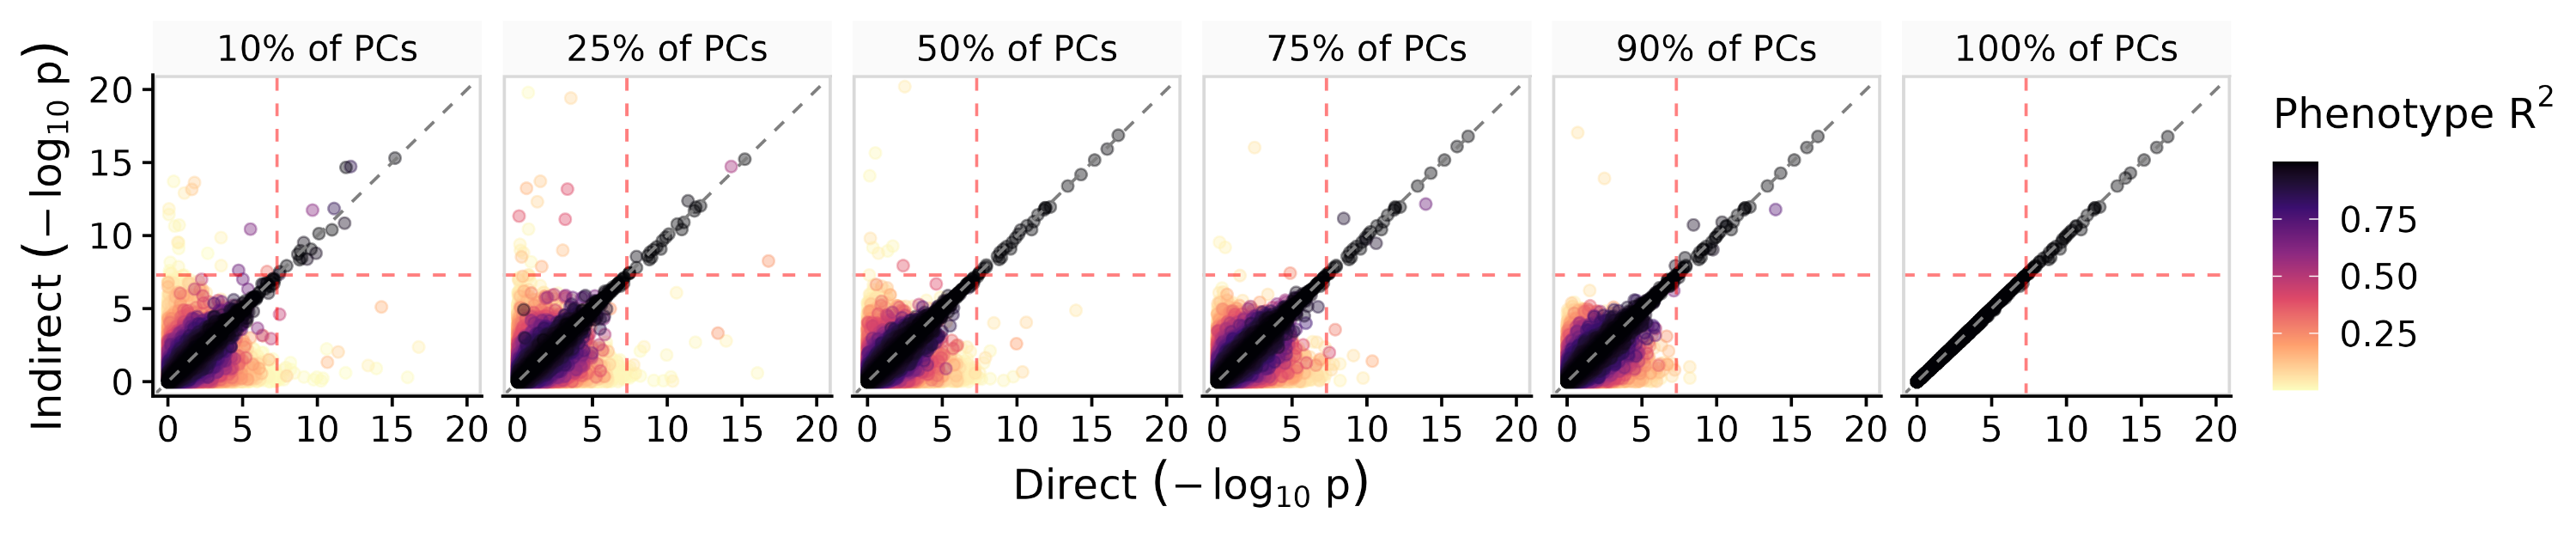

In [31]:
options(repr.plot.width = 12, repr.plot.height = 2.5, repr.plot.res = 250)

scatter <- plot_df %>%
    arrange(r2) %>%
    ggplot(aes(x = p_value_direct, y = p_value, color = r2)) +
    geom_point(alpha = 0.4) +
    geom_abline(slope = 1, intercept = 0, linetype = "dashed", color = "grey50") +
    geom_vline(xintercept = -log10(5e-8), linetype = "dashed", color = "red", alpha = 0.5) +
    geom_hline(yintercept = -log10(5e-8), linetype = "dashed", color = "red", alpha = 0.5) +
    facet_wrap(vars(label), nrow = 1) +
    theme_cowplot() + 
    theme(
        strip.background = element_rect(fill = "grey98")
    ) +
    panel_border() +
    xlab(expression("Direct"~(-log[10]~"p"))) +
    ylab(expression("Indirect"~(-log[10]~"p"))) +
    scale_color_viridis_c(name = expression("Phenotype"~R^2), option = "magma", direction = -1) +
    coord_cartesian(xlim = c(0, 20), ylim = c(0, 20))

save_plot("img/pca_pvalues.png", scatter, base_width = 12, base_height = 2.5, dpi = 400)

grid::grid.raster(png::readPNG("img/pca_pvalues.png"))

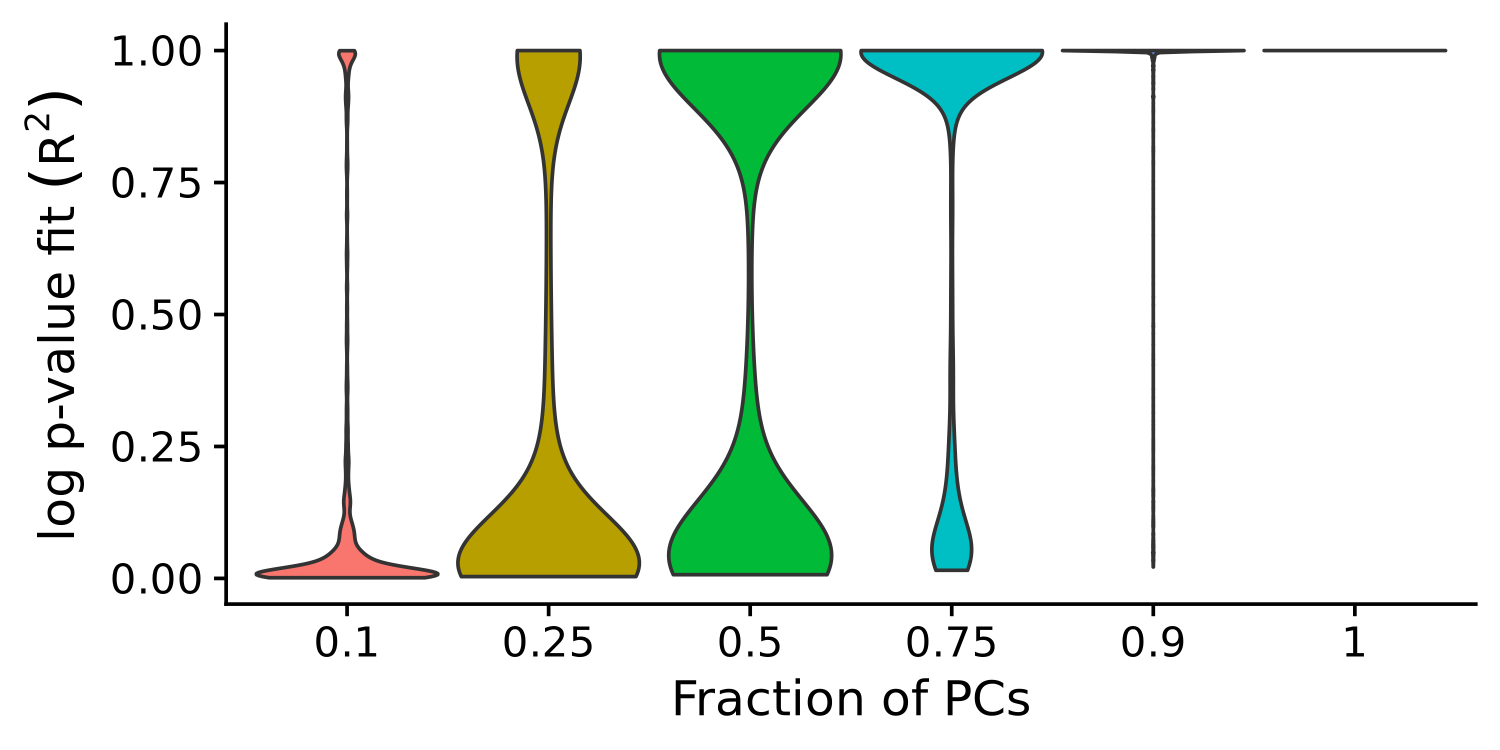

In [6]:
options(repr.plot.width = 6, repr.plot.height = 3, repr.plot.res = 250)

fit_quality_df %>%
    ggplot(aes(x = factor(fraction), y = r2, group = factor(fraction), fill = factor(fraction))) +
    geom_violin(scale = "width") +
    theme_cowplot() +
    theme(legend.position = "none") +
    xlab("Fraction of PCs") +
    ylab(expression("log p-value fit"~(R^2)))